In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

from shortfall.consts import *
from shortfall.strategy import *
import shortfall.gradient.base_cost_models as bcm
import shortfall.gradient.optimize_burn as ob

In [3]:
initial_pledge_projection_period_days = 20
supply_lock_target = 0.3

# define various loss functions to explore
sampling_rate = 30  # sampling rate of the income curve

delta = 250
initial_pledge_vec = np.arange(delta,1000+delta,delta)

In [15]:
def get_base_income(total_pledge, pledge_borrowed):
    base_strategy = StrategyConfig.pledge_limited(total_pledge, 3 * YEAR, False)
    
    pledge_limited_base_stats = bcm.compute_baseline(
        initial_pledge_projection_period_days, 
        supply_lock_target,
        strategy=base_strategy)
    # apply cost model(s) on top of this
    income_apy_cost = bcm.compute_income_borrow_apy(
        pledge_limited_base_stats, 
        pledge_borrowed, 
        apy=bcm.APY, 
        sampling_rate_days=bcm.SAMPLING_RATE_DAYS)
    return income_apy_cost

def get_burn_income(x, pledge_amt):
    shortfall_strategy = StrategyConfig.pledge_limited(pledge_amt, 3 * YEAR, True)
    
    burn_stats = ob.compute_burn(x, strategy=shortfall_strategy)
    indices = np.arange(sampling_rate, len(burn_stats), sampling_rate)
    shortfall_income = jnp.asarray([burn_stats[ii]['net_equity'] for ii in indices])
    shortfall_amount_FIL = burn_stats[ii]['lease']  # this only works for burn variant,
                                                    # this quantity is extracted differently for repay variant
    total_pledged_FIL = shortfall_amount_FIL + pledge_amt
    
    return shortfall_income, shortfall_amount_FIL, total_pledged_FIL

def loss_fn(x, pledge_amt, pct_better=0.8):
    burn_income, shortfall_amount_FIL, total_pledged_FIL = get_burn_income(x, pledge_amt)

    # get the borrowed amount - use that to compute base w/ costs
    base_income = get_base_income(total_pledged_FIL, shortfall_amount_FIL)
    
    # we want base to be > shortfall to encourage lending markets
    loss = np.linalg.norm(base_income - pct_better*burn_income)
    return loss, burn_income, base_income

def diminishing_utility(shortfall_frac, 
                        max_better_than_base=0.8, min_better_than_base=0.6,
                        min_shortfall_pct=0.1, max_shortfall_pct=0.5):
        p1 = (min_shortfall_pct, max_better_than_base)
        p2 = (max_shortfall_pct, min_better_than_base)
        m = (p2[1] - p1[1]) / (p2[0] - p1[0])
        pct_better = m*(shortfall_frac-p1[0]) + p1[1]
        return pct_better
    
def loss_fn_with_marginal_diminishing_utility(x, pledge_amt):
    # Utility = (1+shortfall) * FoFR
    burn_income, shortfall_amount_FIL, total_pledged_FIL = get_burn_income(x, pledge_amt)
    # get the borrowed amount - use that to compute base w/ costs
    base_income = get_base_income(total_pledged_FIL, shortfall_amount_FIL)
    
    shortfall_fraction = shortfall_amount_FIL / total_pledged_FIL
    pct_better = diminishing_utility(shortfall_fraction)

    # we want base to be > shortfall to encourage lending markets
    loss = np.linalg.norm(base_income - pct_better*burn_income)
    return loss, burn_income, base_income
    
def find_closest_idx(a, a0):
    idx = np.abs(a - a0).argmin()
    return a.flat[idx]

In [16]:
max_shortfall_fraction_vec = np.arange(0.1, 0.5+0.1, 0.1)
shortfall_pct_pow_vec = np.linspace(0, 1, 5)

loss_surface_static = np.zeros((len(max_shortfall_fraction_vec), len(shortfall_pct_pow_vec), len(initial_pledge_vec)))
loss_surface_diminshing_utility = np.zeros((len(max_shortfall_fraction_vec), len(shortfall_pct_pow_vec), len(initial_pledge_vec)))
burn_income_dict = {}
base_income_dict = {}
pbar = tqdm(total=loss_surface_static.size)
for ii, max_shortfall_fraction in enumerate(max_shortfall_fraction_vec):
    for jj, shortfall_pct_pow in enumerate(shortfall_pct_pow_vec):
        for kk, initial_pledge in enumerate(initial_pledge_vec):
            x = jnp.asarray([max_shortfall_fraction, shortfall_pct_pow])
            l1, burn_income, base_income = loss_fn(x, initial_pledge)
            l2, _, _ = loss_fn_with_marginal_diminishing_utility(x, initial_pledge)
            loss_surface_static[ii,jj,kk] = l1
            loss_surface_diminshing_utility[ii,jj,kk] = l2
            
            key = '%0.02f,%0.02f,%0.02f' % (max_shortfall_fraction, shortfall_pct_pow, initial_pledge)
            burn_income_dict[key] = burn_income
            base_income_dict[key] = base_income
            
            pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


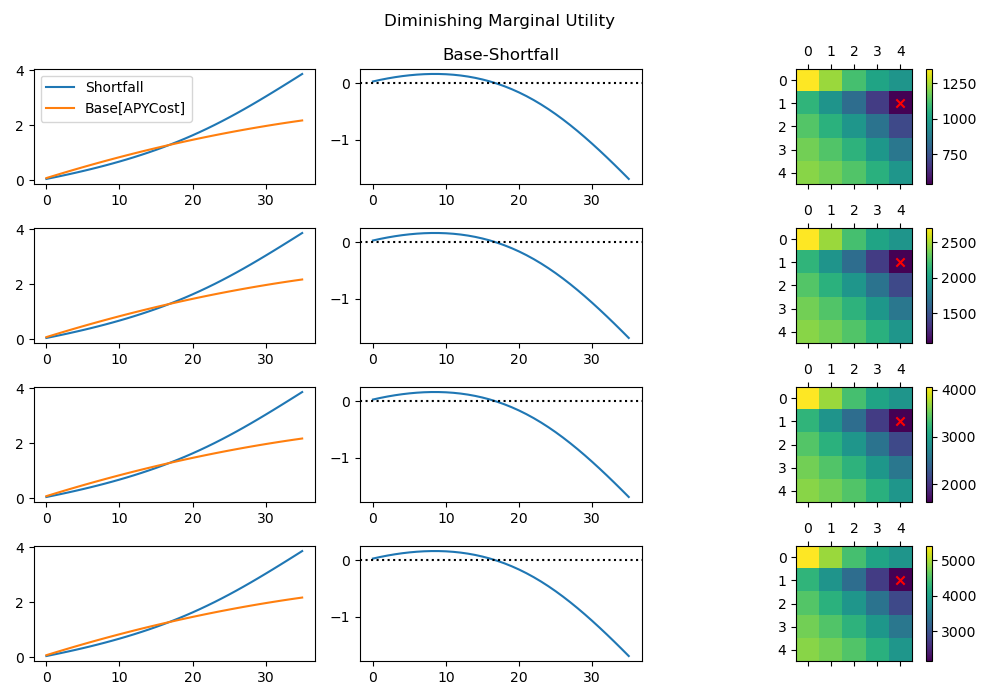

In [18]:
# TODO: verify that the normalization is correct?

plot_diminishing_utility = True

nr = len(initial_pledge_vec)
nc = 3
fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=(10,7))

if plot_diminishing_utility:
    loss_surface_obj = loss_surface_diminshing_utility
else:
    loss_surface_obj = loss_surface_static

for ii, initial_pledge in enumerate(initial_pledge_vec):
    loss_mat = loss_surface_obj[:,:,ii]
    min_point = np.unravel_index(loss_mat.argmin(), loss_mat.shape)
    max_point = np.unravel_index(loss_mat.argmax(), loss_mat.shape)

    best_shortfall_pct = shortfall_pct_pow_vec[min_point[1]]
    best_shortfall_fraction = max_shortfall_fraction_vec[min_point[0]]
    k = '%0.02f,%0.02f,%0.02f' % (best_shortfall_fraction, best_shortfall_pct, initial_pledge)
    ax[ii,0].plot(burn_income_dict[k]/initial_pledge, label='Shortfall')
    ax[ii,0].plot(base_income_dict[k]/initial_pledge, label='Base[APYCost]')
    if ii == 0:
        ax[ii,0].legend()
    
    ax[ii,1].plot((base_income_dict[k]-burn_income_dict[k])/initial_pledge)
    ax[ii,1].axhline(0, linestyle=':', color='k')
    if ii == 0:
        ax[ii,1].set_title('Base-Shortfall')
    
    ax[ii,2].scatter([min_point[1]], [min_point[0]], color='red', marker='x')
    cc = ax[ii,2].matshow(loss_mat)
    fig.colorbar(cc, ax=ax[ii,2])
    # put colorbar here
    
# fig.colorbar(cc, ax=ax[-1,-1])
# ax[-1,-1].axis('off')
if plot_diminishing_utility:
    plt.suptitle('Diminishing Marginal Utility')
else:
    plt.suptitle('Without Diminishing Marginal Utility')
plt.tight_layout()

<IPython.core.display.Javascript object>


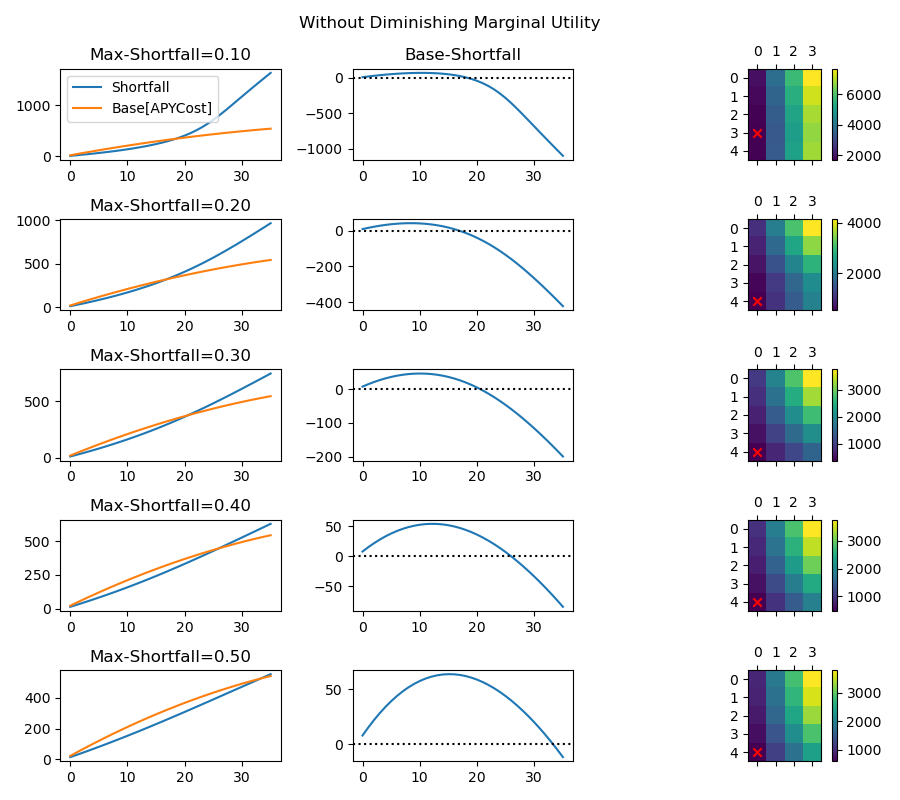

In [29]:
plot_diminishing_utility = False

nr = len(max_shortfall_fraction_vec)
nc = 3
fig, ax = plt.subplots(nrows=nr, ncols=nc, figsize=(9,8))

if plot_diminishing_utility:
    loss_surface_obj = loss_surface_diminshing_utility
else:
    loss_surface_obj = loss_surface_static

for ii, max_shortfall_fraction in enumerate(max_shortfall_fraction_vec):
    loss_mat = loss_surface_obj[ii,:,:]
    min_point = np.unravel_index(loss_mat.argmin(), loss_mat.shape)
    max_point = np.unravel_index(loss_mat.argmax(), loss_mat.shape)

    best_shortfall_pct = shortfall_pct_pow_vec[min_point[0]]
    best_initial_pledge = initial_pledge_vec[min_point[1]]
    k = '%0.02f,%0.02f,%0.02f' % (max_shortfall_fraction, best_shortfall_pct, best_initial_pledge)
    ax[ii,0].plot(burn_income_dict[k], label='Shortfall')
    ax[ii,0].plot(base_income_dict[k], label='Base[APYCost]')
    if ii == 0:
        ax[ii,0].legend()
    ax[ii,0].set_title('Max-Shortfall=%0.02f' % (max_shortfall_fraction,))
    
    ax[ii,1].plot((base_income_dict[k]-burn_income_dict[k]))
    ax[ii,1].axhline(0, linestyle=':', color='k')
    if ii == 0:
        ax[ii,1].set_title('Base-Shortfall')
    
    ax[ii,2].scatter([min_point[1]], [min_point[0]], color='red', marker='x')
    cc = ax[ii,2].matshow(loss_mat)
    fig.colorbar(cc, ax=ax[ii,2])
    # put colorbar here
    
# fig.colorbar(cc, ax=ax[-1,-1])
# ax[-1,-1].axis('off')
if plot_diminishing_utility:
    plt.suptitle('Diminishing Marginal Utility')
else:
    plt.suptitle('Without Diminishing Marginal Utility')
plt.tight_layout()